In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper

In [2]:
def read_csv(filename):
    data = pd.read_csv(filename)
    data.columns = ['name','gender']
    data['name'] = data['name'].str.lower()
    data['genderX'] = data.gender.map(dict(m=1, f=0))
    #split into firstname and last name after first space
    data[['firstname','lastname']]=data['name'].str.rsplit(" ", n=1, expand=True)
    data['namelen'] = [len(str(i)) for i in data['firstname']]
    data = data[(data['namelen'] >= 2)]
    data.firstname.dropna() #drop null values
    data.firstname = data.firstname.astype(str)
    return data

In [3]:
test_file = "../data/test_data.csv"
train_file = "../data/train_data.csv"

data = read_csv(train_file)
test_data = read_csv(test_file)

In [4]:
title_list = ['ms','mrs','smt','ku','mr','master','miss','dr','ca']
test_data.head()
test_data[['first','last']]=test_data['name'].str.rsplit(" ", n=1, expand=True)
test_data['first'][1].split(" ")
test_data['first'] = test_data['first'].str.strip()
has_space = test_data['first'].str.contains(' ')
a = test_data.loc[has_space, 'first'].str.split('\s', expand=True)

In [5]:
filter = a[a[0].isin(title_list)].iloc[: ,0:2]
filter.columns = ['title','first']
test_data.update(filter)
test_data.head()

,name,gender,genderX,firstname,lastname,namelen,first,last
0,isha,f,0,isha,None,4,isha,None
1,smt shyani devi,f,0,smt shyani,devi,10,shyani,devi
2,divya,f,0,divya,None,5,divya,None
3,mansi,f,0,mansi,None,5,mansi,None
4,mazida,f,0,mazida,None,6,mazida,None


In [6]:
# extract is_vowel feature
def is_vowel(data):   
    vowel = ['a','e','i','o','u']
    data['is_vowel'] = [x.strip()[-1:] in vowel for x in data['firstname']]
    data['is_vowel'] = data.is_vowel.astype(int)
    return data

# extract sonorant constant
def is_sonorant(data):
    sonorant = ['y', 'w', 'l', 'r', 'm', 'n','ng']
    data['is_sonorant'] = [x.strip()[-1:] in sonorant for x in data['firstname']]
    data['is_sonorant'] = data.is_sonorant.astype(int)
    return data

In [7]:
data = is_vowel(data)
data = is_sonorant(data)

test_data = is_vowel(test_data)
test_data = is_sonorant(test_data)


In [13]:
test_data.head()

,name,gender,genderX,firstname,lastname,namelen,first,last,is_vowel,is_sonorant
0,isha,f,0,isha,None,4,isha,None,1,0
1,smt shyani devi,f,0,smt shyani,devi,10,shyani,devi,1,0
2,divya,f,0,divya,None,5,divya,None,1,0
3,mansi,f,0,mansi,None,5,mansi,None,1,0
4,mazida,f,0,mazida,None,6,mazida,None,1,0


#### Feature Extraction

#### using sounds or group of letters in start and end as features

In [8]:
def features(name,is_vowel,is_sonorant):
    name = name.lower()
    return {
        'first-letter': name[0], # First letter
        'first2-letters': name[0:2], # First 2 letters
        'first3-letters': name[0:3], # First 3 letters
        'last-letter': name[-1],
        'last2-letters': name[-2:],
        'last3-letters': name[-3:],
        'is_vowel': is_vowel,
        'is_sonorant': is_sonorant
    }

# Vectorizing feature function
features = np.vectorize(features)

In [9]:
X = features(data['firstname'],data['is_vowel'],data['is_sonorant'])
y = data['genderX']


In [10]:
corpus = features(["Raj", "Simran"],1,0)
dv = DictVectorizer()
dv.fit(corpus)

DictVectorizer()

In [12]:
transformed = dv.transform(corpus)

In [13]:
X_train = X
y_train = y

In [14]:
X_test = features(test_data['firstname'],test_data['is_vowel'],test_data['is_sonorant'])
y_test = test_data.genderX

In [15]:
X_test[0]

{'first-letter': 'i',
 'first2-letters': 'is',
 'first3-letters': 'ish',
 'last-letter': 'a',
 'last2-letters': 'ha',
 'last3-letters': 'sha',
 'is_vowel': 1,
 'is_sonorant': 0}

In [17]:
X_train_features = dv.fit_transform(X_train)
X_test_features = dv.transform(X_test)

In [19]:
## Descision Tree
dclf = DecisionTreeClassifier()
# xfeatures =dv.fit_transform(X_train)

dclf.fit(X_train_features, y_train)

DecisionTreeClassifier()

In [22]:
# Accuracy traina and test
print(dclf.score(X_train_features, y_train))
print(dclf.score(X_test_features, y_test))

0.9813101996555463
0.8408249781306776


In [26]:
## performance metrics
dt_pred = dclf.predict(X_test_features)
print("Accuracy Score: {}".format(accuracy_score(y_test, dt_pred)))
print("F1 Score: {}".format(f1_score(y_test, dt_pred)))
print("Recall Score: {}".format(recall_score(y_test, dt_pred)))
print("Confusion Matrix :")
print(confusion_matrix(y_test, dt_pred))

Accuracy Score: 0.8408249781306776
F1 Score: 0.8524283352568701
Recall Score: 0.931107325383305
Confusion Matrix :
[[11327  3720]
 [ 1011 13664]]


In [27]:
def genderpredictor1(name,is_vowel,is_sonorant,clf):
    test_name1 = [name]
    transform_dv =dv.transform(features(test_name1,is_vowel,is_sonorant))
    vector = transform_dv.toarray()
    if clf.predict(vector) == 0:
        print("Female")
        print(clf.predict_proba(vector))
    else:
        print("Male")
        print(clf.predict_proba(vector))

In [28]:
def is_vowel(data):
    vowel = ['a','e','i','o','u']
    data['is_vowel'] = [x.strip()[-1:] in vowel for x in data['firstname']]
    data['is_vowel'] = data.is_vowel.astype(int)
    return data

# extract sonorant constant
def is_sonorant(data):
    sonorant = ['y', 'w', 'l', 'r', 'm', 'n','ng']
    data['is_sonorant'] = [x.strip()[-1:] in sonorant for x in data['firstname']]
    data['is_sonorant'] = data.is_sonorant.astype(int)
    return data
name_list = ["pranjal","Ameya","Kiran","sheetal","Karan",
           "Ms. Jay","Dr. Jay","Dr. Jaya",
            "Akshay","Akshaya"]
vowel = ['a','e','i','o','u']
sonorant = ['y', 'w', 'l', 'r', 'm', 'n','ng']
is_vowel = [x.strip()[-1:] in vowel for x in name_list]
is_vowel = data.is_vowel.astype(int)
is_sonorant = [x.strip()[-1:] in sonorant for x in name_list]
is_sonorant = data.is_sonorant.astype(int)

for i in range(len(name_list)):
    print(name_list[i])
    print(genderpredictor1(name_list[i],is_vowel[i],is_sonorant[i],dclf))

pranjal
Female
[[1. 0.]]
None
Ameya
Male
[[0. 1.]]
None
Kiran
Female
[[0.88888889 0.11111111]]
None
sheetal
Female
[[0.77777778 0.22222222]]
None
Karan
Male
[[0.2 0.8]]
None
Ms. Jay
Female
[[1. 0.]]
None
Dr. Jay
Male
[[0. 1.]]
None
Dr. Jaya
Male
[[0. 1.]]
None
Akshay
Male
[[0.02272727 0.97727273]]
None
Akshaya
Male
[[0. 1.]]
None


--------------------------------------

### Using Multiple Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [41]:
# Reference https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB',XGBClassifier()))

results = []
names=[]
AccuracyDetails={}
for name, model in tqdm(models):
    kfold = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
    cv_results = cross_val_score(model, X_train_features, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    AccuracyDetails[name]=round(cv_results.mean(),4)

print(AccuracyDetails)

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [05:39<01:45, 105.21s/it]

[15:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:44:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:50<00:00, 58.44s/it]

{'LR': 0.9148, 'KNN': 0.9005, 'DTC': 0.905, 'SVM': 0.8553, 'RFC': 0.9143, 'XGB': 0.908}


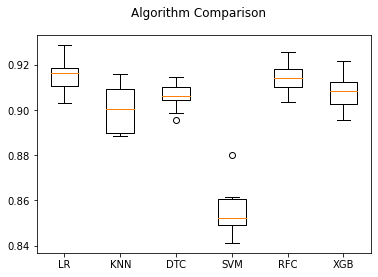

In [31]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [32]:
BestModel = max(AccuracyDetails, key=AccuracyDetails.get)

for eachmodel in models:
    if eachmodel[0]==BestModel:
        model =eachmodel[1]

In [33]:
model.fit(X_train_features, y_train)
predictions = model.predict(X_test_features)

print ("\n********************************************************\n")
print (AccuracyDetails)
print("\nAccuracy_Score",accuracy_score(y_test, predictions)*100)
print ("\n********************************************************\n")


********************************************************

{'LR': 0.9148, 'KNN': 0.9005, 'DTC': 0.9059, 'SVM': 0.8553, 'RFC': 0.914, 'XGB': 0.908}

Accuracy_Score 85.1221317542561

********************************************************



In [34]:
print(BestModel)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

LR
[[11354  3693]
 [  729 13946]]
              precision    recall  f1-score   support

           0       0.94      0.75      0.84     15047
           1       0.79      0.95      0.86     14675

    accuracy                           0.85     29722
   macro avg       0.87      0.85      0.85     29722
weighted avg       0.87      0.85      0.85     29722



### Random Forest

In [38]:
# with cv features
cv_rf_clf = RandomForestClassifier()
cv_rf_clf.fit(X_train_features,y_train)

RandomForestClassifier()

In [39]:
#cv clf metrics
predictions = cv_rf_clf.predict(X_test_features)
print("Accuracy:",accuracy_score(y_test, predictions))
print("f1_score:",f1_score(y_test, predictions))
print("Recall Score: {}".format(recall_score(y_test, predictions)))
print("Confusion Matrix :")
print(confusion_matrix(y_test, predictions))

Accuracy: 0.8526680573312697
f1_score: 0.8642212644569162
Recall Score: 0.9496422487223168
Confusion Matrix :
[[11407  3640]
 [  739 13936]]


In [40]:
name_list = ["sheetal","balaji","Saba","Tarun","Karan",
           "Ms. Jay","Dr. Jai","Dr. Jaya",
            "neelam","simran"]

vowel = ['a','e','i','o','u']
sonorant = ['y', 'w', 'l', 'r', 'm', 'n','ng']
is_vowel = [x.strip()[-1:] in vowel for x in name_list]
is_vowel = data.is_vowel.astype(int)
is_sonorant = [x.strip()[-1:] in sonorant for x in name_list]
is_sonorant = data.is_sonorant.astype(int)

for i in range(len(name_list)):
    print(name_list[i])
    print(genderpredictor1(name_list[i],is_vowel[i],is_sonorant[i],cv_rf_clf))

sheetal
Female
[[0.5380305 0.4619695]]
None
balaji
Male
[[0.035 0.965]]
None
Saba
Female
[[0.8575 0.1425]]
None
Tarun
Male
[[0.01 0.99]]
None
Karan
Male
[[0.28835657 0.71164343]]
None
Ms. Jay
Male
[[0.24464286 0.75535714]]
None
Dr. Jai
Male
[[0.23232967 0.76767033]]
None
Dr. Jaya
Female
[[0.535 0.465]]
None
neelam
Female
[[0.81399512 0.18600488]]
None
simran
Female
[[0.64 0.36]]
None


-----------